## Nonlinear fitting example

We'll use an artificial dataset to fit a model with 5 parameters, 

$$
y(x) = b_1 \exp\left(-b_2 x\right) + \frac{b_3}{b_5\sqrt{2\pi}} \exp\left(-\tfrac12\frac{(x-b_4)^2}{b_5^2}\right)
$$

It's the sum of a decaying exponential background, and a Gaussian peak.

We first load some standard packages, including `scipy.optimize` and `lmfit` for the nonlinear optimisation.

In [2]:
import os, sys
import numpy as np
from numpy import exp, pi, sqrt

from numpy import linspace
from scipy.optimize import leastsq

import pandas as pd
from matplotlib import pyplot

import scipy.optimize as optimization
# conda install -c conda-forge lmfit
from lmfit import minimize, Parameters 

### Loading and displaying the dataset



<ErrorbarContainer object of 3 artists>

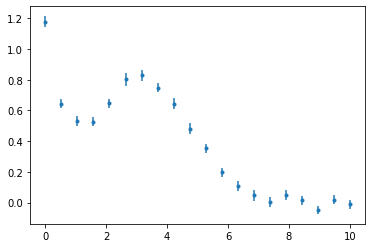

In [3]:
data = pd.read_csv("exppeak.txt", header=0, delim_whitespace=True)
# note: three ways to refer to a particular column
data.iloc[:,1]
data.loc[:,'x']
data.x
pyplot.errorbar(data.x, data.y, yerr=data.sigma, fmt='.')

### Defining the model and testing it

We now create a function that computes the predicted values for a given set of parameters $b_1\dots,b_5$:

In [4]:
def model_peak(x, b1, b2, b3, b4, b5):
    return b1*exp(-b2*x) + b3/(b5*sqrt(2*np.pi))*exp(-0.5*(x-b4)**2 / b5**2)

We test it by superposing the prediction and the data (in this artificial example, we know the "true" parameters that were used to generate the dataset).

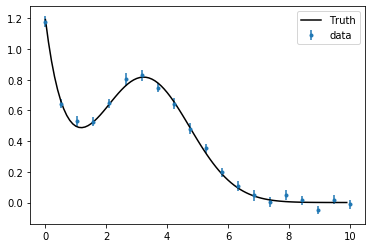

In [5]:
xx = np.arange(0,10,0.1)
truth = model_peak(xx, 1.12, 1.52, 3, 3.26,  1.48)
pyplot.errorbar(data.loc[:,'x'], data.loc[:,'y'], yerr=data.loc[:,'sigma'], fmt='.', label='data')
pyplot.plot(xx, truth, 'k', label='Truth')
pyplot.legend(loc='best')

## Simple nonlinear fitting with `scipy.optimize.curve_fit`

Perhaps the simplest interface for nonlinear fitting is the `curve_fit` function, which takes as arguments the model defined above, the data, and a set of initial guess parameters. The output of the function is the optimised parameters, and the covariance matrix for the fitted parameters:

In [6]:
import scipy.optimize as optimization
p0 = [1, 1, 1, 4,  1]
popt, pcov = optimization.curve_fit(model_peak, data.x, data.y, p0, data.sigma)
popt

array([1.08251862, 1.59378021, 3.11029724, 3.20655998, 1.55177204])

In [7]:
pcov

array([[ 0.00100275, -0.00034778, -0.00109506,  0.00055618, -0.00067476],
       [-0.00034778,  0.01995825,  0.01065553, -0.00575757,  0.00480145],
       [-0.00109506,  0.01065553,  0.00957323, -0.00355233,  0.00408678],
       [ 0.00055618, -0.00575757, -0.00355233,  0.00289486, -0.00165942],
       [-0.00067476,  0.00480145,  0.00408678, -0.00165942,  0.00249512]])

We can visualise the output to confirm that the fit is reasonable.

Text(0, 0.5, 'y')

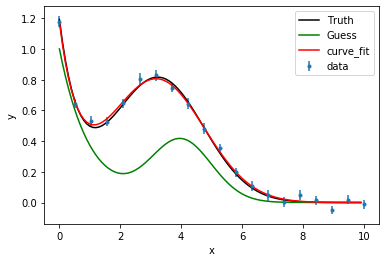

In [10]:
guess = model_peak(xx, *p0)
fit = model_peak(xx, *popt)
pyplot.errorbar(data.loc[:,'x'], data.loc[:,'y'], yerr=data.loc[:,'sigma'], fmt='.', label='data')
pyplot.plot(xx, truth, 'k-', label='Truth')
pyplot.plot(xx, guess, 'g', label='Guess')
pyplot.plot(xx, fit, 'r', label='curve_fit')
pyplot.legend(loc='best')
pyplot.xlabel("x")
pyplot.ylabel("y")

### More optimisation methods via `lmfit.minimize`

`curve_fit` is simple to use, but not very flexible. We'll try another alternative here, which requires a little more effort in the setup, but provides more options such as different algorithms for the search.

In [11]:
from lmfit import minimize, Parameters, Model, report_fit
from scipy.optimize import leastsq


Here we need to provide `minimize` with the normalised residuals (note: they are not squared, as minimize will square them internally for least-square based methods):

In [19]:
def residuals(pars, x, y, eps):
    A1 = pars['A1'].value
    Decay = pars['Decay'].value
    A2 = pars['A2'].value
    Position = pars['Position'].value
    Width = pars['Width'].value

    model = A1*exp(-Decay*x) + A2/(Width*sqrt(2*np.pi))*exp(-0.5*(x-Position)**2 / Width**2)
    
    return (y-model) / eps


The rest of the setup consists in creating a `Parameters` object holding the information for all free parameters (at a minimum, their name and initial guess for the value, but one can also set constraints). We can then call the minimize function:

In [20]:
params = Parameters()
params.add('A1', value=1.0)
params.add('Decay', value=1.5)
params.add('A2', value=0.5)
params.add('Position', value=3.0)
params.add('Width', value=1.5)

out = minimize(residuals, params, args=(data.x, data.y, data.sigma), method='leastsq')

print("# Fit using leastsq:")
report_fit(out)

# Fit using leastsq:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 20
    # variables        = 5
    chi-square         = 10.0399205
    reduced chi-square = 0.66932803
    Akaike info crit   = -3.78326151
    Bayesian info crit = 1.19539985
[[Variables]]
    A1:        1.08251850 +/- 0.03166571 (2.93%) (init = 1)
    Decay:     1.59378187 +/- 0.14126643 (8.86%) (init = 1.5)
    A2:        3.11029830 +/- 0.09784307 (3.15%) (init = 0.5)
    Position:  3.20655937 +/- 0.05380360 (1.68%) (init = 3)
    Width:     1.55177259 +/- 0.04995053 (3.22%) (init = 1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(A2, Width)       = 0.836
    C(Decay, A2)       = 0.771
    C(Decay, Position) = -0.757
    C(Decay, Width)    = 0.680
    C(A2, Position)    = -0.675
    C(Position, Width) = -0.617
    C(A1, Width)       = -0.427
    C(A1, A2)          = -0.353
    C(A1, Position)    = 0.326


We can compare the fitted parameters to those obtained via curve_fit:

In [24]:

with np.printoptions(precision=3, suppress=True):
    print("# Fit using curve_fit:")
    print(popt)

# Fit using curve_fit:
[1.083 1.594 3.11  3.207 1.552]


and their uncertainty, which are estimated by the diagonal components of the covariance matrix:

In [28]:

with np.printoptions(precision=3, suppress=True):
    print("# Uncertainties using curve_fit:")
    print(np.sqrt(np.diag(pcov)))
    

# Uncertainties using curve_fit:
[0.032 0.141 0.098 0.054 0.05 ]


We could also obtain such undertainty estimates "manually", by evaluating the Hessian matrix at the optimum position in the parameter space:

In [35]:
# conda install -c conda-forge numdifftools 
import numdifftools as nd

# vals = out.params.valuesdict()
opt = np.array(out.params)

# residuals(pars, x, y, eps)
def objective(p):
    model = model_peak(data.x, *p)
    chi2 = np.sum(((data.y-model) / data.sigma)**2)
    return chi2

H = nd.Hessian(objective)(popt)

with np.printoptions(precision=3, suppress=True):
    print(H)

[[2146.055 -379.742  191.581 -583.046  609.5  ]
 [-379.742  290.208 -176.365  354.949 -134.703]
 [ 191.581 -176.365  645.87    36.894 -642.168]
 [-583.046  354.949   36.894 1307.605  -38.95 ]
 [ 609.5   -134.703 -642.168  -38.95  1983.361]]


The covariance matrix is obtained as the inverse of half the Hessian matrix. The uncertainty of each parameter are the square root of the diagonal elements of this covariance matrix.

In [36]:
cov = np.linalg.inv(0.5*H)
with np.printoptions(precision=3, suppress=True):
    print(cov)
    print("# Uncertainties from the covariance matrix:")
    print(np.sqrt(np.diag(cov)))

[[ 0.001 -0.    -0.002  0.001 -0.001]
 [-0.     0.029  0.016 -0.008  0.007]
 [-0.002  0.016  0.014 -0.005  0.006]
 [ 0.001 -0.008 -0.005  0.004 -0.002]
 [-0.001  0.007  0.006 -0.002  0.004]]
# Uncertainties from the covariance matrix:
[0.039 0.171 0.119 0.065 0.061]


Changing the method produces similar results:

In [37]:
out2 = minimize(residuals, params, args=(data.x, data.y, data.sigma), method='lbfgsb')
print("# Fit using lbfgsb:")
report_fit(out2)

# Fit using lbfgsb:
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 120
    # data points      = 20
    # variables        = 5
    chi-square         = 10.0399205
    reduced chi-square = 0.66932803
    Akaike info crit   = -3.78326151
    Bayesian info crit = 1.19539985
[[Variables]]
    A1:        1.08251844 +/- 0.03164248 (2.92%) (init = 1)
    Decay:     1.59378189 +/- 0.13987566 (8.78%) (init = 1.5)
    A2:        3.11029856 +/- 0.09720750 (3.13%) (init = 0.5)
    Position:  3.20655917 +/- 0.05329030 (1.66%) (init = 3)
    Width:     1.55177273 +/- 0.04973770 (3.21%) (init = 1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(A2, Width)       = 0.834
    C(Decay, A2)       = 0.767
    C(Decay, Position) = -0.753
    C(Decay, Width)    = 0.675
    C(A2, Position)    = -0.668
    C(Position, Width) = -0.609
    C(A1, Width)       = -0.426
    C(A1, A2)          = -0.352
    C(A1, Position)    = 0.324


_Download this page [as a Jupyter notebook](https://github.com/vuw-scps/python-physics/raw/master/notebooks/phys345/fitting_02_basic.ipynb) or as a [standalone Python script](https://github.com/vuw-scps/python-physics/raw/master/scripts/phys345/fitting_02_basic.py)._